In [4]:
# !pip install spacy

In [6]:
# !pip install sentence_transformers --index-url=https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com

In [8]:
# !pip install en_core_web_sm-3.1.0-py3-none-any.whl

In [9]:
import spacy
import torch
import en_core_web_sm

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

nlp = spacy.load("en_core_web_sm")

In [81]:
df_combined_web_iva_search = pd.read_csv("s3://adl-core-sagemaker-studio/external/IVA/combined_new_adult-child_outer_new.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0,1,2,4,5,9,10,11,12,13,14,15,16,17,18,20,21,23,24,25,26,27,28,29,31,33,39,41,56,57,58,59,63,64,65,67,68,70,71,74,75,77,78,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,106,108,109,110,111,112,113,114,115,116,117,118,119,122,123,124,125,126,127,128,129,130,131,132,134,135,136,137,138,155,156,159,160,161,164,165) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [82]:
df_combined_web_iva_search[['input','search_text','page_name']].head()

,input,search_text,page_name
0,step child a dependent?,NaN,NaN
1,how do i change my dependent daycare deduction,NaN,NaN
2,Child last name change,NaN,NaN
3,i am trying to add my children as beneficiarie...,NaN,NaN
4,how much timeoff do i get after the birth of m...,NaN,NaN


In [83]:
df_iva = pd.read_csv("s3://adl-core-sagemaker-studio/external/Deepali/IVA_cleaned_labelled(session_id_added).csv")

In [84]:
df_iva.columns

Index(['Unnamed: 0', 'entry_id', 'client_id', 'person_internal_id',
       'input_orig', 'labels', 'input_cleaned', 'input_cleaned_dl',
       'next_unit_hit', 'previous_unit_hit', 'unit_name', 'response_text',
       'session_id'],
      dtype='object')

In [85]:
df_iva1 = df_iva.drop(['Unnamed: 0','entry_id','client_id','person_internal_id','next_unit_hit',
             'previous_unit_hit','response_text','session_id'], axis=1)

In [86]:
df_iva1.head()

,input_orig,labels,input_cleaned,input_cleaned_dl,unit_name
0,Open enrollment,Enrollment,open enrol,open enrollment,Annual Enrollment Clarifier
1,enroll in hra,HRA,enrol hra,enroll in hra,Health Reimbursement Account Clarifier
2,TIRE DISCOUNT,Discounts Issue,tire discount,tire discount,Discounts Clarifier
3,eligible,HSA related,elig,eligible,Health Savings Account (HSA) Eligible Expenses
4,Need to update my mail address,General Acount issue,need updat mail address,need to update my mail address,Manage Address


In [87]:
df_iva2 = df_iva1.drop(['input_cleaned','input_cleaned_dl'], axis=1)

In [88]:
df_iva2.head()

,input_orig,labels,unit_name
0,Open enrollment,Enrollment,Annual Enrollment Clarifier
1,enroll in hra,HRA,Health Reimbursement Account Clarifier
2,TIRE DISCOUNT,Discounts Issue,Discounts Clarifier
3,eligible,HSA related,Health Savings Account (HSA) Eligible Expenses
4,Need to update my mail address,General Acount issue,Manage Address


In [89]:
df_iva3 = pd.read_csv("s3://adl-core-sagemaker-studio/external/Deepali/IVA_cleaned_labelled_merged.csv")

In [90]:
df_iva3.head()

,client_id,person_internal_id,session_id,input_orig,response_text,unit_name
0,245,342020022,13134207,does my fsa carry over,This information isn't available yet.,Flexible Spending Account (FSA) Rollover
1,936,12351089,13134208,hi | leave/time off,Hi there. What would you like help with today?...,Hello | Paid Time Off Clarifier
2,936,32861032,13134215,How much does covid pay cover,For possible impacts to your benefits related ...,Natural Disaster
3,5888,379001056,13134216,I want to roll my future builder into an ira |...,It looks like you're asking about your FutureB...,401k/403b/457 Clarifier | I Don't Know
4,1040,147720041,13134224,cancel dental,There are 2 ways to cancel your benefits cover...,Cancel Coverage


In [91]:
df_iva3 = df_iva3.rename(columns={'input_orig':'input_orig_1'})

In [92]:
# df_iva3 = df_iva3.drop(['client_id','person_internal_id','session_id','response_text','unit_name'], axis=1)

In [93]:
df_iva3['input_orig_1'].head(10).to_list()

['does my fsa carry over',
 'hi | leave/time off',
 'How much does covid pay cover',
 'I want to roll my future builder into an ira | nvm',
 'cancel dental',
 'Mobile App name | What is the name of the mobile application? | What is the name of the mobile app used to be able to login?',
 'I want to start a FSA during open enrollment. This is not a life change. | annual enrollment | See feedback | I want to set up a flexible spending account. I am not seeing the page to do that.',
 'quickgroup learning',
 'what is my retirement savings balance | Does this insurance cover Covid test?',
 'new employee emrollment']

In [94]:
# Split the 'col' column using '|' delimiter
df_iva3['input_orig_1'] = df_iva3['input_orig_1'].str.split('|')

In [95]:
# Explode the 'col' column to expand it row-wise
df_iva3 = df_iva3.explode('input_orig_1')

In [96]:
# Reset the index
df_iva3 = df_iva3.reset_index(drop=True)

In [97]:
df_iva3.head()

,client_id,person_internal_id,session_id,input_orig_1,response_text,unit_name
0,245,342020022,13134207,does my fsa carry over,This information isn't available yet.,Flexible Spending Account (FSA) Rollover
1,936,12351089,13134208,hi,Hi there. What would you like help with today?...,Hello | Paid Time Off Clarifier
2,936,12351089,13134208,leave/time off,Hi there. What would you like help with today?...,Hello | Paid Time Off Clarifier
3,936,32861032,13134215,How much does covid pay cover,For possible impacts to your benefits related ...,Natural Disaster
4,5888,379001056,13134216,I want to roll my future builder into an ira,It looks like you're asking about your FutureB...,401k/403b/457 Clarifier | I Don't Know


In [102]:
df_concat = pd.concat([df_combined_web_iva_search, df_iva2, df_iva3], axis=0)

In [103]:
df_concat.head()

,agent_entitlement_client_name,agent_entitlement_access_key,channel,companytracking_clientid,companytracking_companyid,companytracking_companyname,companytracking_multitenantid,entry_id,entry_order,entry_type,...,page_load_elapsed_time,mobile_app_type,session_create_date_cst_timezone_partition,platform_id_y,search_text,search_results,session_created_timestamp,input_orig,labels,input_orig_1
0,Enterprise,00000000-0000-0000-0000-000000000000,Web,8141.0,staples,staples,NaN,2292881.0,7.0,Typed Input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Enterprise,00000000-0000-0000-0000-000000000000,Web,8141.0,staples,staples,NaN,2330416.0,2.0,Typed Input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Enterprise,00000000-0000-0000-0000-000000000000,Web,8141.0,staples,staples,NaN,2615890.0,2.0,Typed Input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Enterprise,00000000-0000-0000-0000-000000000000,Web,8141.0,staples,staples,NaN,1332591.0,2.0,Typed Input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Enterprise,00000000-0000-0000-0000-000000000000,Web,8141.0,staples,staples,NaN,2421907.0,2.0,Typed Input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_concat.shape

(5906010, 173)

In [105]:
# df_concat.columns.to_list()

In [139]:
df_concat2 = df_concat[['input','input_orig_1','input_orig','search_text','page_name','labels','unit_name']]

In [140]:
df_concat2.head()

,input,input_orig_1,input_orig,search_text,page_name,labels,unit_name
0,step child a dependent?,NaN,NaN,NaN,NaN,NaN,Benefits Eligibility For Stepchildren
1,how do i change my dependent daycare deduction,NaN,NaN,NaN,NaN,NaN,Adding or Removing a Dependent _CORE_
2,Child last name change,NaN,NaN,NaN,NaN,NaN,Updating Legal Name
3,i am trying to add my children as beneficiarie...,NaN,NaN,NaN,NaN,NaN,Life Insurance Beneficiaries
4,how much timeoff do i get after the birth of m...,NaN,NaN,NaN,NaN,NaN,Paid Time Off Accrual


In [143]:
# select the columns to stack
cols_to_stack = ['input', 'input_orig_1', 'input_orig']

# stack the columns using melt
stacked = pd.melt(df_concat2, id_vars=['search_text', 'page_name', 'labels','unit_name'], 
                  value_vars=cols_to_stack, var_name='stacked_cols', value_name='stacked_input')

In [144]:
stacked.head()

,search_text,page_name,labels,unit_name,stacked_cols,stacked_input
0,NaN,NaN,NaN,Benefits Eligibility For Stepchildren,input,step child a dependent?
1,NaN,NaN,NaN,Adding or Removing a Dependent _CORE_,input,how do i change my dependent daycare deduction
2,NaN,NaN,NaN,Updating Legal Name,input,Child last name change
3,NaN,NaN,NaN,Life Insurance Beneficiaries,input,i am trying to add my children as beneficiarie...
4,NaN,NaN,NaN,Paid Time Off Accrual,input,how much timeoff do i get after the birth of m...


In [145]:
# df_concat2 = df_concat2.rename(columns={'input_orig':'input_orig_1'})

In [146]:
# df_concat2.head()

In [147]:
stacked.shape

(17718030, 6)

In [148]:
# Use melt() to stack columns 'A', 'B', and 'C' into a single column 'value'
# df_concat2 = pd.melt(df_concat2, value_vars=['input', 'input_orig', 'input_orig'], var_name='column', value_name='stacked_input')

In [149]:
# df_concat2.head()

In [150]:
# df_stacked_concat2.shape

In [151]:
stacked.drop_duplicates(inplace=True)

In [152]:
stacked.shape

(4378178, 6)

In [153]:
stacked.dropna(subset=['search_text','page_name','stacked_input'], how='all', inplace=True)

In [154]:
stacked.shape

(3907681, 6)

In [155]:
stacked = stacked.drop(['stacked_cols'], axis=1)

In [156]:
stacked.head()

,search_text,page_name,labels,unit_name,stacked_input
0,NaN,NaN,NaN,Benefits Eligibility For Stepchildren,step child a dependent?
1,NaN,NaN,NaN,Adding or Removing a Dependent _CORE_,how do i change my dependent daycare deduction
2,NaN,NaN,NaN,Updating Legal Name,Child last name change
3,NaN,NaN,NaN,Life Insurance Beneficiaries,i am trying to add my children as beneficiarie...
4,NaN,NaN,NaN,Paid Time Off Accrual,how much timeoff do i get after the birth of m...


In [157]:
import string
import nltk
nltk.data.path.append('../../nltk_data')
from nltk.corpus import stopwords
# nltk.download('stopwords')


In [158]:
def clean_text(df, text_cols):
    # Create a new dataframe to hold the cleaned text columns
    cleaned_df = pd.DataFrame()
    
    # Define the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Clean each text column and add it to the cleaned dataframe
    for text_col in text_cols:
        text_list = df[text_col].tolist()
        text_list = [str(text) for text in text_list]
        text_list = [text if text.strip() and not
                     set(text).issubset(set(string.punctuation + string.whitespace)) else '' 
                     for text in text_list]
        text_list = [x.lower() for x in text_list]
        translator = str.maketrans(string.punctuation + string.digits + "_", " " * len(
            string.punctuation + string.digits + "_"))
        cleaned_list = []
        for text in text_list:
            cleaned_text = text.translate(translator)
            cleaned_text = ' '.join(cleaned_text.split())
            cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
            cleaned_list.append(cleaned_text)
        cleaned_df[text_col] = cleaned_list
    
    # Add the non-text columns to the cleaned dataframe
    for col in df.columns:
        if col not in text_cols:
            cleaned_df[col] = df[col]
    
    return cleaned_df


In [159]:
stacked.sample()

,search_text,page_name,labels,unit_name,stacked_input
11056943,NaN,NaN,NaN,Vision Insurance Card,I need a vision benefits id card


In [160]:
df_concat3 = clean_text(stacked, text_cols=['stacked_input','search_text','page_name','unit_name'])
# cleaned_stacked, removed_rows = clean_text(stacked, text_cols=['stacked_input','search_text','page_name'])

In [161]:
df_concat3.head(5)

,stacked_input,search_text,page_name,unit_name,labels
0,step child dependent,nan,nan,benefits eligibility stepchildren,NaN
1,change dependent daycare deduction,nan,nan,adding removing dependent core,NaN
2,child last name change,nan,nan,updating legal name,NaN
3,trying add children beneficiaries life ins,nan,nan,life insurance beneficiaries,NaN
4,much timeoff get birth child,nan,nan,paid time accrual,NaN


In [162]:
df_concat3.shape

(3907681, 5)

In [163]:
df_concat4 = df_concat3.replace('nan', '')
df_concat4.head()

,stacked_input,search_text,page_name,unit_name,labels
0,step child dependent,,,benefits eligibility stepchildren,NaN
1,change dependent daycare deduction,,,adding removing dependent core,NaN
2,child last name change,,,updating legal name,NaN
3,trying add children beneficiaries life ins,,,life insurance beneficiaries,NaN
4,much timeoff get birth child,,,paid time accrual,NaN


In [164]:
df_concat4['text'] = df_concat4[['stacked_input', 'search_text', 'page_name']].apply(lambda x: ' '.join([str(i) for i in x if not pd.isna(i)]), axis=1)

In [165]:
df_concat4.drop(['stacked_input','search_text','page_name'], inplace=True, axis=1)

In [166]:
df_concat4.head()

,unit_name,labels,text
0,benefits eligibility stepchildren,NaN,step child dependent
1,adding removing dependent core,NaN,change dependent daycare deduction
2,updating legal name,NaN,child last name change
3,life insurance beneficiaries,NaN,trying add children beneficiaries life ins
4,paid time accrual,NaN,much timeoff get birth child


In [167]:
# df_concat4.drop(['input_orig'], inplace=True, axis=1)

In [168]:
# df_concat4.head()

In [169]:
df_concat4.drop_duplicates(subset=['text'], inplace=True)

In [170]:
df_concat4.shape

(1336481, 3)

In [171]:
# Get the value counts of the 'labels' column
label_counts = df_concat4['unit_name'].value_counts()
print(sum(label_counts>500))
# Filter the dataframe to only include rows where the label count is greater than 10000
df_concat5 = df_concat4[df_concat4['unit_name'].isin(label_counts[label_counts > 10000].index)]

# Get the shape of the resulting filtered dataframe
df_concat5_shape = df_concat5.shape

294


In [172]:
df_concat5_shape

(115888, 3)

In [173]:
df_concat5['unit_name'].value_counts()

know                           36007
contact us                     18407
benefits clarifier             14650
medical benefits clarifier     12475
manage dependents clarifier    12177
tying units                    12006
child care plus information    10166
Name: unit_name, dtype: int64

In [174]:
df_concat4[df_concat4['text']=='nan '].value_counts()

Series([], dtype: int64)

In [175]:
df_concat4.to_parquet('cc_df_concat5.parquet')

### finding the texts which contain exact phrases from synonyms list

In [35]:
words_3 = ['day care', 'creche', 'childcare', 'daycare', 'after school care', 'pre school', 'child', 'baby',
           'infant', 'girl child', 'play school', 'boy child', 'Adolescent', 'nursery', 'preschool', 'day nursery',
           'playschool', 'kindergarten', 'childminding', 'babysitting', 'babysitter', 'nanny', 'children supervision', 
           'toddler care', 'baby sitter', 'children', 'child supervision', 'childs', 'stepchild', 'step daughter', 'step son', 
           'grandchildren', 'grandchild', 'daughter', 'son', 'stepchildren', 'childhood', 'day cares', 'childrent', 'daycares', 
           'childplus']


words_4 = list(set([word.lower() for word in words_3]))

len(words_4)

41

In [24]:
df_concat4 = pd.read_parquet('cc_df_concat5.parquet')

In [25]:
mask = (df_concat4['text'].str.contains(r'\b(' + '|'.join(words_4) + r')\b', case=False, na=False))

df_concat4['category'] = ''
df_concat4.loc[mask, 'category'] = 'Child care'
# df_combined_web_iva_search.loc[df_combined_web_iva_search['category'] == '', 'category'] = 'Other'

df_concat4.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,unit_name,labels,text,category
0,benefits eligibility stepchildren,NaN,step child dependent,Child care
1,adding removing dependent core,NaN,change dependent daycare deduction,Child care
2,updating legal name,NaN,child last name change,Child care
3,life insurance beneficiaries,NaN,trying add children beneficiaries life ins,Child care
4,paid time accrual,NaN,much timeoff get birth child,Child care


In [26]:
# df_concat4[df_concat4['category']=='Child care'].sample(20)

In [27]:
df_concat4[df_concat4['category']=='Child care'].shape

(126152, 4)

In [28]:
df_concat4['category'].value_counts()

              1210329
Child care     126152
Name: category, dtype: int64

### get text which are similar to phrases in synonnyms list for texts other than which are filtered above

In [30]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(sentence1, sentence2):
    # Load the SBERT model
    # model = SentenceTransformer('all-MiniLM-L6-v2')
    model = SentenceTransformer('all-mpnet-base-v2')

    # Encode the sentences and calculate embeddings
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

    # Move the embeddings to the CPU and convert to numpy arrays
    embeddings_cpu = embeddings.cpu().numpy()

    # Calculate cosine similarity
    similarity = cosine_similarity(embeddings_cpu[0].reshape(1, -1), embeddings_cpu[1].reshape(1, -1))

    return similarity


In [31]:
# get_similarity("mom", "daughter")
get_similarity("parental", "daughter")

array([[0.54044855]], dtype=float32)

In [36]:
import torch
from sentence_transformers import SentenceTransformer
import pandas as pd

def find_similar_sentences(df, sentences, phrases, model, threshold=0.73, category_name='Child care', device='cuda', batch_size=32):
    # Set the device
    device = torch.device(device)

    # Move the model to the device
    model = model.to(device)

    # Encode the phrases using the model
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True, device=device)

    # Initialize empty lists to store the similar sentences and phrases
    similar_sentences = []
    similar_phrases = []

    # Make sure the sentences input is in the correct format
    if isinstance(sentences, str):
        sentences = [sentences]

    # Split the sentences into batches
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    with torch.no_grad():
        # Iterate over the batches
        for batch_sentences in batches:
            # Encode the batch of sentences using the model
            sentence_embeddings = model.encode(batch_sentences, convert_to_tensor=True, device=device)

            # Calculate the cosine similarity between the sentence embeddings and the phrase embeddings
            cosine_scores = torch.nn.functional.cosine_similarity(sentence_embeddings.unsqueeze(1), phrase_embeddings.unsqueeze(0), dim=-1)

            # Iterate over the batch of sentences and similarity scores and append the sentence to the list if it meets the threshold for at least one phrase
            for j, scores_list in enumerate(cosine_scores):
                mask = scores_list >= threshold
                if mask.any():
                    similar_sentences.extend([batch_sentences[j]] * mask.sum().item())
                    similar_phrases.extend([phrases[i] for i in torch.nonzero(mask).flatten()])

    # Remove duplicates from similar_sentences and similar_phrases while preserving order
    seen_sentences = set()
    seen_phrases = set()
    unique_sentences = []
    unique_phrases = []
    for sentence, phrase in zip(similar_sentences, similar_phrases):
        if sentence not in seen_sentences:
            seen_sentences.add(sentence)
            seen_phrases.add(phrase)
            unique_sentences.append(sentence)
            unique_phrases.append(phrase)

    # Create a new DataFrame containing only the rows with text that is in the set of similar sentences
    similar_df = df[df['text'].isin(unique_sentences)]
    similar_df['synonym_phrase'] = unique_phrases
    similar_df['category'] = category_name
    return similar_df

In [53]:
import time
start_time = time.time()
# find_similar_sentences(df, sentences, phrases, model, threshold=0.73, category_name='Child care', device='cuda', batch_size=32)
similar_df = find_similar_sentences(
    df_concat4,
    df_concat4[df_concat4['category']=='']['text'].to_list(),
    words_4,
    model,
    threshold=0.95,
    category_name='Child care',
    device='cuda',
    batch_size=32
)

elapsed_time = time.time() - start_time
print(elapsed_time)

1466.0988144874573


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [54]:
similar_df

,unit_name,labels,text,category,synonym_phrase
11551,know,NaN,childrens,Child care,child
62797,know,NaN,childrenb,Child care,childs
90973,know,NaN,grandchildern,Child care,grandchild
95448,know,NaN,childf,Child care,childrent
123645,,NaN,grandchildern,Child care,grandchild
125619,,NaN,childrens,Child care,child
125800,,NaN,stepchildrent,Child care,stepchild
125952,,NaN,childcarew,Child care,childcare
127026,,NaN,childcarepls,Child care,childcare
127720,,NaN,daycarea,Child care,daycares


In [55]:
# similar_df['text'].to_list()

In [56]:
similar_df.to_csv('cc_similar_df_95%_sim_v2.csv')

In [57]:
get_similarity("wife", "daughter")

array([[0.55472887]], dtype=float32)

In [58]:
similar_df['category'].value_counts()

Child care    14
Name: category, dtype: int64

In [59]:
only_CC_df = pd.concat([df_concat4[df_concat4['category']=='Child care'], 
                       similar_df]).sample(frac=1)

In [60]:
only_CC_df.shape

(126166, 5)

In [61]:
only_CC_df.drop_duplicates(inplace=True)

In [62]:
only_CC_df.shape

(126166, 5)

In [63]:
non_similar_df = df_concat4[~df_concat4['text'].isin(only_CC_df['text'])]

non_similar_df['category'] = 'Other'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
df_concatenated = pd.concat([only_CC_df, non_similar_df]).sample(frac=1).reset_index(drop=True)

In [65]:
pd.set_option('display.max_colwidth', None)

In [66]:
df_concatenated.shape

(1336481, 5)

In [67]:
df_concatenated['category'].value_counts()

Other         1210315
Child care     126166
Name: category, dtype: int64

In [69]:
## get 5000 rows including all labels where category is Other in same proportion as original 

from sklearn.model_selection import StratifiedKFold

# Define the number of folds to use for cross-validation
n_splits = 5

# Create a StratifiedKFold object to generate the cross-validation folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define an empty DataFrame to store the sampled data
Other_sample_df = pd.DataFrame()

# Split the DataFrame into training and testing sets using cross-validation
for train_index, test_index in skf.split(df_concatenated[df_concatenated['category'] == 'Other'], 
                                         df_concatenated[df_concatenated['category'] == 'Other']['unit_name']):
    # Obtain a random sample of 5000 rows from the training set
    train_df = df_concatenated.iloc[train_index]
    train_df_other = train_df[train_df['category'] == 'Other']
    train_df_other_sample = train_df_other.sample(n=126166*3//n_splits, random_state=42)
    Other_sample_df = pd.concat([Other_sample_df, train_df_other_sample])
    
# Print the value counts of the label column in the original DataFrame and the sample
print('Original dataset:')
print(df_concatenated[df_concatenated['category'] == 'Other']['unit_name'].value_counts(normalize=True))
print('\nSampled dataset:')
print(Other_sample_df['unit_name'].value_counts(normalize=True))


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Original dataset:
know                                                                                                                                                                                                           2.403011e-02
contact us                                                                                                                                                                                                     1.483498e-02
benefits clarifier                                                                                                                                                                                             9.860243e-03
medical benefits clarifier                                                                                                                                                                                     9.398380e-03
enroll health benefits medical dental vision                                                          

In [71]:
CC_model_train_df = pd.concat([df_concatenated[df_concatenated.category=='Child care'], 
                              Other_sample_df]).sample(frac=1).reset_index(drop=True)#.to_excel('fasttext_EC_model_training_data.xlsx')

In [80]:
CC_model_train_df.sample(10)

,unit_name,labels,text,category,synonym_phrase
405044,dependent clarifier,NaN,child covered plan right,Child care,NaN
128581,dependent turns,NaN,child turns march handle enrollment,Child care,NaN
487320,health savings account hsa clarifier,NaN,hsa acceptance page continue let us,Other,NaN
215174,enroll clarifier account clarifier login user id username clarifier new user,NaN,never logged site,Other,NaN
142199,submit payment health benefits medical dental vision,NaN,pay medical dental benefits,Other,NaN
423440,buy vacation,NaN,hi tell buy pto,Other,NaN
192673,lost forgot password issues logging password request options website issues,NaN,login wed site,Other,NaN
132240,cancel coverage,NaN,remove cindy insurance,Other,NaN
335085,mental health coverage mental health coverage,NaN,going doctor bipolar depression severe anxiety meds gives longer strong enough says need psychiatrist want get stronger meds depression getting worse need help,Other,NaN
228907,manage dependents health benefits medical dental vision enrollment clarifier manage annual enrollment,NaN,completed enrollment completed enrollment something changed need make corrections,Other,NaN


In [82]:
CC_model_train_df.category.value_counts()

Other         378495
Child care    126166
Name: category, dtype: int64

In [81]:
# df_cc_under_sampled = df_concatenated[df_concatenated['category']=='Child care'].sample(
#     df_concatenated[df_concatenated['category']=='Other'].shape[0]*(100//25), random_state=1)

In [42]:
# df_cc_other_final = pd.concat([df_cc_under_sampled, df_other]).sample(frac=1).reset_index(drop=True)

In [43]:
# df_concatenated[(df_concatenated.text.str.contains('child')) & (df_concatenated.category=='Other')]

In [83]:
pd.reset_option('display.max_colwidth')

In [84]:
# df_concatenated[df_concatenated.category=='Elder care'].to_excel('fasttext_only_elder_care_training_data.xlsx')

In [85]:
## number og labels in label col where value of category col is Other
# df_concatenated[df_concatenated['category'] == 'Other']['labels'].nunique()

In [86]:
# df_cc_other_final = df_cc_other_final.drop('session_start_cst', axis=1)

In [91]:
CC_model_train_df['labels'].isnull().sum()

504661

In [90]:
CC_model_train_df['category'].isnull().sum()

0

In [89]:
CC_model_train_df['text'].isnull().sum()

0

In [92]:
# df_concatenated['labels'] = df_concatenated['labels'].fillna('empty')

In [93]:
# EC_model_train_df = pd.concat([df_concatenated2[df_concatenated2.category=='Elder care'], 
#                               Other_sample_df]).sample(frac=1).reset_index(drop=True)#.to_excel('fasttext_EC_model_training_data.xlsx')

In [94]:
# EC_model_train_df.head()

In [95]:
CC_model_train_df.category.value_counts(normalize=True)

Other         0.749999
Child care    0.250001
Name: category, dtype: float64

In [96]:
CC_model_train_df.shape

(504661, 5)

In [97]:
CC_model_train_df.to_csv('CC_model_train_df.csv')

In [98]:
# df_concatenated = pd.read_csv('cc_df_concatenated_v1.csv')

### text preprocess

In [99]:
import re
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def count_intnt_entits(doc):
    intents = [token.text for token in doc if token.pos_ == 'VERB']
    entities = [token.text for token in doc if token.pos_ in {'NOUN', 'PROPN', 'ADJ', 'NUM', 'ADV'}]
    return len(intents), len(entities)

def extract_ner_entities(doc, sentence):
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

def length_entities(list_entities):
    if (list_entities == np.nan or list_entities is None or list_entities == ''):
        return 0
    else:
        return len(list_entities)

def filter_named_entities(doc, text):
    filtered_words = [token.text for token in doc if token.ent_type_ not in ['ORG', 'PERSON', 'GPE', 'LOC', 'FAC']]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

def process_text(text):
    doc = nlp(text)
    intents, entities = count_intnt_entits(doc)
    ner_entities = extract_ner_entities(doc, text)
    len_ner_entities = length_entities(ner_entities)
    filtered_text = filter_named_entities(doc, text)
    return intents, entities, ner_entities, len_ner_entities, filtered_text

def text_preprocess(dataframe):
    dataframe = dataframe.drop_duplicates()

    texts = dataframe['text'].tolist()
    with ProcessPoolExecutor(max_workers=96) as executor:
        processed_results = list(executor.map(process_text, texts))

    intents, entities, ner_entities, len_ner_entities, filtered_texts = zip(*processed_results)
    
    dataframe['no_of_intents'] = intents
    dataframe['no_of_entities'] = entities
    dataframe['ner_enities'] = ner_entities
    dataframe['len_ner_enities'] = len_ner_entities
    dataframe['text'] = filtered_texts
    
    dataframe = dataframe[dataframe['len_ner_enities'] > 0]
    dataframe['text'] = dataframe['text'].str.strip()
    dataframe = dataframe.drop(['no_of_intents', 'no_of_entities', 'ner_enities', 'len_ner_enities'], axis=1)
    
    return dataframe


In [100]:
import time
start_time = time.time()

df_combined_cc_model_data_2 = text_preprocess(CC_model_train_df)

elapsed_time = time.time() - start_time
print(elapsed_time)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

232.22880244255066


In [101]:
df_combined_cc_model_data_2.shape

(77376, 5)

In [102]:
df_combined_cc_model_data_2.columns

Index(['unit_name', 'labels', 'text', 'category', 'synonym_phrase'], dtype='object')

In [103]:
df_combined_cc_model_data_2['category'].value_counts()

Other         55240
Child care    22136
Name: category, dtype: int64

In [107]:
df_combined_cc_model_data_2.to_parquet('final_cc_model_data_v9.parq')
# df_combined_cc_model_data_2.to_parquet('final_cc_model_data_v7.parq')


In [4]:
import pandas as pd
df_combined_cc_model_data_2 = pd.read_parquet('final_cc_model_data_v7.parq')

In [5]:
df_combined_cc_model_data_2.to_csv('final_cc_model_data_v7.csv')

In [108]:
# df_unseen = pd.read_excel('unseen_data.xlsx')

In [109]:
# df_unseen.head()

In [110]:
import pandas as pd
# df_combined_cc_model_data_2 = pd.read_parquet('final_cc_model_data_v8.parq')[['text', 'category']].rename(
#     columns={'category':'label'})
# df_combined_cc_model_data_2.sample(2)
df_combined_cc_model_data_2 = pd.read_parquet('final_cc_model_data_v9.parq')[['text', 'category']].rename(
    columns={'category':'label'})
df_combined_cc_model_data_2['label'].value_counts()

Other         55240
Child care    22136
Name: label, dtype: int64

In [111]:
df_combined_cc_model_data_2.shape

(77376, 2)

In [112]:
df_combined_cc_model_data_2.isnull().sum()

text     0
label    0
dtype: int64

In [113]:
df_combined_cc_model_data_2 = df_combined_cc_model_data_2.dropna(subset=['text'])

In [114]:
data = df_combined_cc_model_data_2.copy()

In [115]:
# # Load your dataset
texts = data.text.values  # List of text samples
labels =  data.label.values  # List of corresponding labels

In [117]:
# # Step 1: Install necessary libraries
# !pip install sentence-transformers
# !pip install lightgbm
# !pip install joblib
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib

In [118]:
# Step 2: Import libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Load the SentenceTransformer model
model = SentenceTransformer('all-mpnet-base-v2')

In [119]:
# # Step 4: Prepare training data
# texts = ["This is the first text.", "Another example text.", ...]
# labels = [0, 1, ...]

# Step 5: Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, 
                                                                      test_size=0.005, 
                                                                      random_state=42)

In [120]:
test_texts.shape

(387,)

In [121]:
# Step 6: Encode the text samples
train_encodings = model.encode(train_texts)
test_encodings = model.encode(test_texts)

# Step 7: Train a classifier with LightGBM
classifier = lgb.LGBMClassifier()
classifier.fit(train_encodings, train_labels)

# Step 8: Make predictions and evaluate the model
predictions = classifier.predict(test_encodings)
accuracy = accuracy_score(test_labels, predictions)
test_df = pd.DataFrame({'text':test_texts, 'actual_label':test_labels, 
                        'predicted_label':predictions})
test_df.to_csv('cc_test_df.csv')

print("Accuracy:", accuracy)

# Step 9: Save the model
joblib.dump(classifier, 'Bert_CC_model/cc_model_v1.pkl')

Accuracy: 0.979328165374677


['Bert_CC_model/cc_model_v1.pkl']

Classification Report:
Label: Child care
  Precision: 0.9741379310344828
  Recall: 0.9576271186440678
  F1-Score: 0.9658119658119658
  Support: 118
Label: Other
  Precision: 0.981549815498155
  Recall: 0.9888475836431226
  F1-Score: 0.9851851851851852
  Support: 269
F1 Score: 0.9792781053762966
Accuracy: 0.979328165374677
Precision: 0.9792898610622033
Recall: 0.979328165374677
AUC: 0.9732373511435951


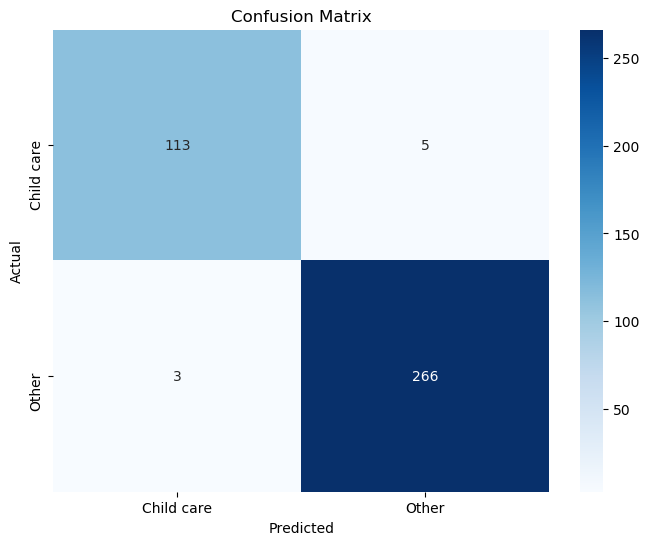

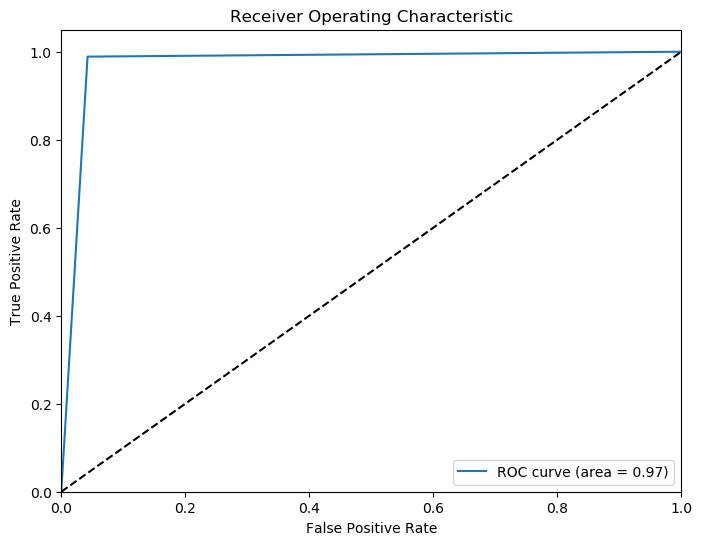

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Step 15: Generate the confusion matrix
cm = confusion_matrix(test_labels, predictions)
label_names = ['Child care', 'Other']

# Convert labels to numerical values
test_labels_numeric = np.where(np.array(test_labels) == 'Child care', 0, 1)
predictions_numeric = np.where(np.array(predictions) == 'Child care', 0, 1)

# Calculate additional metrics
classification_metrics = classification_report(test_labels_numeric, predictions_numeric, target_names=label_names, output_dict=True)
fpr, tpr, thresholds = roc_curve(test_labels_numeric, predictions_numeric)
auc_score = roc_auc_score(test_labels_numeric, predictions_numeric)

# Print classification report
print("Classification Report:")
for label in label_names:
    print(f"Label: {label}")
    print(f"  Precision: {classification_metrics[label]['precision']}")
    print(f"  Recall: {classification_metrics[label]['recall']}")
    print(f"  F1-Score: {classification_metrics[label]['f1-score']}")
    print(f"  Support: {classification_metrics[label]['support']}")

# Print additional metrics
print("F1 Score:", classification_metrics['weighted avg']['f1-score'])
print("Accuracy:", classification_metrics['accuracy'])
print("Precision:", classification_metrics['weighted avg']['precision'])
print("Recall:", classification_metrics['weighted avg']['recall'])
print("AUC:", auc_score)

# Step 16: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# prediction: 

### loading data for prediction

In [124]:
# !pip install lightgbm

In [125]:
import time
start_time = time.time()

In [126]:
import spacy
import en_core_web_sm
import lightgbm 

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from sentence_transformers import SentenceTransformer

nlp = spacy.load("en_core_web_sm")

import boto3
import pandas as pd
import pyarrow.parquet as pq
import s3fs

import string
import nltk
nltk.data.path.append('../../nltk_data')
from nltk.corpus import stopwords
# nltk.download('stopwords')

In [4]:
# Initialize S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and prefix where the Parquet files are stored
# s3://adl-core-sagemaker-studio/external/IVA/IVA_daily/
# s3://adl-core-sagemaker-studio/external/IVA/Search_daily/
# s3://adl-core-sagemaker-studio/external/Deepali/iva-data(3-apr).csv
bucket_name = 'adl-core-sagemaker-studio'
# prefix = 'external/web_clickstream/clickstream20230403_20230403/'
prefix = 'external/Deepali/iva_data/'
prefix = 'external/Deepali/iva_data/'


# List all Parquet files in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
if 'Contents' in response:
    # parquet_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.parq')]
    csv_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.csv')]
else:
    # parquet_files = []
    csv_files = []

# Read Parquet files and concatenate them together
dfs = []
s3fs = s3fs.S3FileSystem()

# for file in parquet_files:
for file in csv_files:
    # Read the Parquet file into a PyArrow table
    s3_key = f"{bucket_name}/{file}"
    # dataset = pq.ParquetDataset(f"s3://{s3_key}", filesystem=s3fs)
    df = pd.read_csv(f"s3://{s3_key}")
    # table = dataset.read()
    
    # Convert the PyArrow table to a Pandas DataFrame
    # df = table.to_pandas()
    dfs.append(df)

# Concatenate all the DataFrames together
if dfs:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    print(concatenated_df.head())
else:
    # print("No Parquet files found.")
    print("No csv files found.")

   person_internal_id  client_id  \
0            84580040       3349   
1           261800048       1012   
2           189230015       6352   
3           412710098        695   
4           412710098        695   

                                               input  \
0                                      pet insurance   
1  how can I find Cigna human resources contact i...   
2                            Associate Discount Card   
3                                          Tax forms   
4                                            HSA tax   

                             unit_name    session_start_utc  session_id  \
0           Coverage for Pet Insurance  2023-04-03 00:06:54    19429827   
1  Medical Carrier Contact Information  2023-04-03 00:09:11    19429853   
2     Employee/Associate Discount Card  2023-04-03 00:16:57    19429937   
3                  Tax Forms Clarifier  2023-04-03 00:18:18    19429950   
4                          Tying Units  2023-04-03 00:18:18    19429950

In [127]:
import pandas as pd
concatenated_df = pd.read_excel('iva_4th_april.xlsx')

In [128]:
concatenated_df.shape

(97880, 3)

In [129]:
concatenated_df = concatenated_df.drop_duplicates(subset=['input'])

In [130]:
concatenated_df.shape

(17645, 3)

In [131]:
concatenated_df.isna().sum()

client_id             0
person_internal_id    0
input                 1
dtype: int64

In [132]:
concatenated_df = concatenated_df.dropna(subset=['input'])

In [133]:
# # Words to exclude
# exclude_words = ['maternity', 'pregnancy', 'fertility','Maternal',
#                  'Gestation', 'Conception', 'Reproduction', 'Obstetrics', 'Infertility', 'Prenatal',
#                  'Procreation', 'Embryo', 'Contraception', 'family planning','familyplanning']


# # Filter the DataFrame
# concatenated_filtered_df = concatenated_df[~concatenated_df['input'].str.contains('|'.join(exclude_words), case=False)]

# # Print the filtered DataFrame
# print(concatenated_filtered_df.shape)

In [134]:
# concatenated_df.head()

In [135]:

def clean_text(df, text_cols):
    # Create a new dataframe to hold the cleaned text columns
    cleaned_df = pd.DataFrame()
    
    # Define the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Clean each text column and add it to the cleaned dataframe
    for text_col in text_cols:
        text_list = df[text_col].tolist()
        text_list = [str(text) for text in text_list]
        text_list = [text if text.strip() and not
                     set(text).issubset(set(string.punctuation + string.whitespace)) else '' 
                     for text in text_list]
        text_list = [x.lower() for x in text_list]
        translator = str.maketrans(string.punctuation + string.digits + "_", " " * len(
            string.punctuation + string.digits + "_"))
        cleaned_list = []
        for text in text_list:
            cleaned_text = text.translate(translator)
            cleaned_text = ' '.join(cleaned_text.split())
            cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
            cleaned_list.append(cleaned_text)
        cleaned_df[text_col] = cleaned_list
    
    # Add the non-text columns to the cleaned dataframe
    for col in df.columns:
        if col not in text_cols:
            cleaned_df[col] = df[col]
    
    return cleaned_df


In [136]:
# cleaned_concatenated_df = clean_text(concatenated_df, text_cols=['page_name'])
cleaned_concatenated_df = clean_text(concatenated_df, text_cols=['input'])

In [137]:
# words_3 = ['day care', 'creche', 'childcare','daycare','after school care',
#            'pre school', 'child', 'baby',
#             'infant','girl child', 'play school', 
#            'boy child','Adolescent',
#  'nursery', 'preschool', 'after schoolcare', 'day nursery', 
#   'playschool', 'kindergarten', 'childminding', 'babysitting',
#            'babysitter', 
#  'nanny', 'children supervision', 'toddler care', 'kindergarten',
# 'child minding', 'baby sitting', 'baby sitter', 'children',
#  'childrensupervision','child supervision', 'childsupervision', 'children supervision',
#            'toddlercare','foster', 'childs','childrens',
#            'stepchild','step daughter', 'step son', 'grandchildren','grandchild','daughter','son', 
#           'stepchildren',"children's", 'childhood',
#            'stepchildren',
#           'day cares','childrent','daycares',
#           'childplus']

# words_4 = set([word.lower() for word in words_3])

# len(words_4)


In [138]:
words_3 = ['day care', 'creche', 'childcare', 'daycare', 'after school care', 'pre school', 'child', 'baby',
           'infant', 'girl child', 'play school', 'boy child', 'Adolescent', 'nursery', 'preschool', 'day nursery',
           'playschool', 'kindergarten', 'childminding', 'babysitting', 'babysitter', 'nanny', 'children supervision', 
           'toddler care', 'baby sitter', 'children', 'child supervision', 'childs', 'stepchild', 'step daughter', 'step son', 
           'grandchildren', 'grandchild', 'daughter', 'son', 'stepchildren', 'childhood', 'day cares', 'childrent', 'daycares', 
           'childplus']


words_4 = set([word.lower() for word in words_3])

len(words_4)

41

In [139]:
# # mask = (cleaned_concatenated_df['input'].str.contains('|'.join(words_4), case=False))

# # cleaned_concatenated_df['Contains_syn'] = ''
# # cleaned_concatenated_df.loc[mask, 'Contains_syn'] = 'yes'

# # Create 'contain_syn' column
# cleaned_concatenated_df['contain_syn'] = cleaned_concatenated_df['input'].str.contains('|'.join(words_4), case=False)

# # Convert boolean values to 'Yes' and 'No'
# cleaned_concatenated_df['contain_syn'] = cleaned_concatenated_df['contain_syn'].map({True: 'Yes', False: 'No'})

# # Print the updated DataFrame
# print(cleaned_concatenated_df.head())

# # df_combined_web_iva_search.loc[df_combined_web_iva_search['category'] == '', 'category'] = 'Other'

# # cleaned_concatenated_df.head(5)
# # # Apply the function to create a new column
# # cleaned_concatenated_df['Contains_syn'] = cleaned_concatenated_df.apply(check_phrases, axis=1)

In [140]:
# cleaned_concatenated_df.to_csv('cc_cleaned_concatenated_df.csv')

In [141]:
# concatenated_df.columns

In [142]:
# concatenated_df= concatenated_df[['client_id','person_internal_id','page_name']]
# cleaned_concatenated_df= cleaned_concatenated_df[['client_id','person_internal_id','input', 'contain_syn']]

In [143]:
# concatenated_df.head()

In [144]:
cleaned_concatenated_df.shape

(17644, 3)

In [145]:
# cleaned_concatenated_df.head()

In [146]:
import re
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial

# def count_intnt_entits(doc):
#     intents = [token.text for token in doc if token.pos_ == 'VERB']
#     entities = [token.text for token in doc if token.pos_ in {'NOUN', 'PROPN', 'ADJ', 'NUM', 'ADV'}]
#     return len(intents), len(entities)

# def extract_ner_entities(doc, sentence):
#     entities = [(entity.text, entity.label_) for entity in doc.ents]
#     return entities

# def length_entities(list_entities):
#     if (list_entities == np.nan or list_entities is None or list_entities == ''):
#         return 0
#     else:
#         return len(list_entities)

# def filter_named_entities(doc, text):
#     filtered_words = [token.text for token in doc if token.ent_type_ not in ['ORG', 'PERSON', 'GPE', 'LOC', 'FAC']]
#     filtered_text = ' '.join(filtered_words)
#     return filtered_text

# def process_text(text):
#     doc = nlp(text)
#     intents, entities = count_intnt_entits(doc)
#     ner_entities = extract_ner_entities(doc, text)
#     len_ner_entities = length_entities(ner_entities)
#     filtered_text = filter_named_entities(doc, text)
#     return intents, entities, ner_entities, len_ner_entities, filtered_text

# def text_preprocess(dataframe, col='reportingfields_fieldvalue1'):
#     dataframe = dataframe.drop_duplicates()
#     texts = dataframe[col].tolist()
#     # texts = dataframe['text'].tolist()
#     with ProcessPoolExecutor(max_workers=96) as executor:
#         processed_results = list(executor.map(process_text, texts))

#     intents, entities, ner_entities, len_ner_entities, filtered_texts = zip(*processed_results)
    
#     dataframe['no_of_intents'] = intents
#     dataframe['no_of_entities'] = entities
#     dataframe['ner_enities'] = ner_entities
#     dataframe['len_ner_enities'] = len_ner_entities
#     dataframe[col]= filtered_texts
    
#     dataframe = dataframe[dataframe['len_ner_enities'] > 0]
#     dataframe[col] = dataframe[col].str.strip()
#     dataframe = dataframe.drop(['no_of_intents', 'no_of_entities', 'ner_enities', 'len_ner_enities'], axis=1)
    
#     return dataframe


In [147]:
# text_preprocessed_cleaned_concatenated_df = text_preprocess(cleaned_concatenated_df, col='reportingfields_fieldvalue1' )

In [157]:
# Step 10: Load the model
import joblib

loaded_model = joblib.load('Bert_CC_model/cc_model_v1.pkl')
model = SentenceTransformer('all-mpnet-base-v2')

# Step 12: Encode the text samples from the Parquet file
encodings = model.encode(cleaned_concatenated_df['input'].fillna(' ').tolist())

# Step 13: Make predictions for the encoded samples
cleaned_concatenated_df['prediction'] = loaded_model.predict(encodings)
cleaned_concatenated_df['confidence_level'] = np.max(loaded_model.predict_proba(encodings), axis=1)
cleaned_concatenated_df['contain_syn'] = cleaned_concatenated_df['input'].apply(
    lambda x: 'yes' if any(phrase in x for phrase in list(words_4)) else 'no')

# Step 14: Save the predictions in an Excel file
# cleaned_concatenated_df.to_excel('cc_iva_4april_predictions_v1.xlsx', index=False)

elapsed_time = time.time() - start_time
print(elapsed_time)

51108.574212789536


In [167]:
cleaned_concatenated_df.sample(30)

,input,client_id,person_internal_id,prediction,confidence_level,contain_syn
17168,careplus information,NaN,NaN,Other,0.963541,no
7586,withdraw get approved,936.0,165561004.0,Other,0.993508,no
8094,didnt receive document mailbox provides link e...,NaN,NaN,Other,0.996801,no
2491,dom benefits,NaN,NaN,Other,0.934262,no
13236,hi legal insurance access legal advisors,NaN,NaN,Other,0.979506,no
78,wellness fund,NaN,NaN,Other,0.974300,no
5842,loloan,NaN,NaN,Other,0.995568,no
9080,sent cash sale addendum portal also uploaded t...,NaN,NaN,Other,0.976331,no
10159,change k contributions,NaN,NaN,Other,0.996727,no
5425,nd md,5035.0,254750020.0,Other,0.992235,no


In [168]:
cleaned_concatenated_df.to_excel('cc_iva_4april_predictions_v1.xlsx', index=False)

In [ ]:
df = pd.read_excel('cc_search_3april_predictions.xlsx')

In [ ]:
list_unique_words = list(words_4)

In [ ]:
# Encode phrases using the SentenceTransformer model
phrase_embeddings = model.encode(list_unique_words)

In [ ]:
# Function to calculate similarity between a text and the phrases
def calculate_similarity(text):
    text = str(text)
    text_embedding = model.encode([text])
    similarity_scores = cosine_similarity(text_embedding, phrase_embeddings)
    
    pos = np.argmax(similarity_scores[0])
    return similarity_scores[0][pos], list_unique_words[pos]


In [ ]:
df['Similarity_Scores'] = df[df['Contains_syn'].isna()]['search_text'].apply(calculate_similarity)
# df['Similarity_Scores'] = df[df['Contains_syn'].isna()]['search_text'].apply(calculate_similarity)


In [ ]:
df[(df['prediction']=='Child care') & df['Contains_syn'].isna()].to_csv('cc_cat_not_contain_syn.csv')

In [ ]:
df[df['Contains_syn']=='']

In [85]:
# np.max(loaded_model.predict_proba(encodings[:10]), axis=1)

In [77]:
# loaded_model.predict(encodings[:10])

In [78]:
# loaded_model.classes_

In [81]:
list_of_texts = ["senior-citizen?care expense reimbursement", 
                 "elderly*care plus",
                 "aging care home", "retirees care reimbirsement", 
                 "senior assistance required","Daycare@expense reimbursement",
                 "baby care licensed", "oldsters care home","geriatric care home",
                 "contentPage 2023 Eldercare!!!!!!!!!!!!!****@_Subsidy","Elder statesmen care",
                 "Elder women care","Silver generation care",
                 "contentPage {}[]/\|?><,.;:!@#+\t\n\r\f\v 2023 Elder care Subsidy","gerontology care",
                 "Elderly Care Plus Information"]


/tmp/ipykernel_74027/3565708624.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')
/tmp/ipykernel_74027/3565708624.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['text'] = df3['text'].apply(filter_named_entities)


,text,prediction,probability
0,senior citizen care expense reimbursement,Elder care,0.999973
1,elderly care plus,Elder care,0.999985
2,aging care home,Elder care,0.999983
3,retirees care reimbirsement,Elder care,0.999841
4,senior assistance required,Elder care,0.999977
5,daycare expense reimbursement,Other,0.999982
6,baby care licensed,Other,0.999976
7,oldsters care home,Other,0.991685
8,contentpage eldercare subsidy,Elder care,0.999982
9,elder statesmen care,Elder care,0.999982


### convert saved model .bin and config.json to .pkl compatible files

In [ ]:
# convert saved model .bin and config.json to .pkl compatible files
from transformers import AutoConfig, AutoModelForSequenceClassification
import torch
import pickle

# Load the model configuration from the config.json file
config = AutoConfig.from_pretrained('EC_model_outer_combined_texts_data_v6', num_labels=2)

# Load the model from the binary file using the configuration
model = AutoModelForSequenceClassification.from_pretrained('EC_model_outer_combined_texts_data_v6', config=config)

# Save the model and configuration as a pickle file
with open('EC_model_outer_combined_texts_data_v6/EC_model.pkl', 'wb') as f:
    pickle.dump((config, model.state_dict()), f)

## tagging the unseen_data for analysisng the predictions

### finding the texts which contain exact phrases from synonyms list

In [41]:
words_3 = ['older parent','older people','grand parents','elder','old parents','elder women',
 'silver generation','aged people', 'older women','older men','old age home','elder',
 'aged',
 'elderly people',
 'senior assistance',
 'aging-in-place',
 'aged population',
 'golden agers',
 'aging in place',
 'grey generation',
 'silver generation',
 'senior health',
 'aged population',
 'elderly companion',
 'golden agers',
 'senior citizen',
 'elder support',
 'elderly',
 'senior members',
 'elder population',
 'elderly residents',
 'senior assistance',
 'oldsters',
 'grey generation',
 'aging population',
 'elder statesmen',
 'elderly',
 'elderly people',
 'aging',
 'elderly residents',
 'elder',
 'elder women',
 'senior',
 'elder generation',
 'gerontology',
 'elderly population',
 'senior members',
 'retirees',
 'elderly population',
 'eldercare',
 'geriatric',
 'elder statesmen',
 'age related',
 'retirees',
 'third age population',
 'aging population',
 'elder population',
 'oldsters',
 'third age population','eldercae', 'eldercarr', 'eldermann', 
'aged home','eldercre','eldery','elderman','elders','eldercrae',]
words_4 = list(set([word.lower() for word in words_3]))
len(words_4)

49

In [42]:
df_cleaned = pd.DataFrame()
df_cleaned['text'] =cleaned_text_list
df_cleaned.head(5)

,text
0,welcomeuserfollowup
1,medical plan credit
2,welcomeuser
3,general purpose loans
4,chiropractor visits


In [43]:
mask = (df_cleaned['text'].str.contains(r'\b(' + '|'.join(words_4) + r')\b', case=False, na=False))

df_cleaned['category'] = ''
df_cleaned.loc[mask, 'category'] = 'Elder care'
# df_combined_web_iva_search.loc[df_combined_web_iva_search['category'] == '', 'category'] = 'Other'

df_cleaned.head(5)

/tmp/ipykernel_74027/3427755096.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = (df_cleaned['text'].str.contains(r'\b(' + '|'.join(words_4) + r')\b', case=False, na=False))


,text,category
0,welcomeuserfollowup,
1,medical plan credit,
2,welcomeuser,
3,general purpose loans,
4,chiropractor visits,


In [45]:
df_cleaned[df_cleaned['category']=='Elder care'].sample(1)

,text,category
5666,ongoing elderly care,Elder care


In [46]:
df_cleaned[df_cleaned['category']=='Elder care'].shape

(13, 2)

### get text which are similar to phrases in synonnyms list for texts other than which are filtered above

In [50]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [51]:
def find_similar_sentences(df, sentences, phrases, threshold=0.95, category_name = 'Elder care'):
    # encode the phrases using the model
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
    
    # initialize an empty list to store the similar sentences
    similar_sentences = []
    
    # iterate over the sentences
    for sentence in sentences:
        # encode the sentence using the model
        sentence_embedding = model.encode(sentence, convert_to_tensor=True)
        # reshape the sentence embedding to a 2D array
        sentence_embedding = sentence_embedding.reshape(1, -1)
        
        # calculate the cosine similarity between the sentence embedding and each phrase embedding
        cosine_scores = 1 - cosine_distances(sentence_embedding, phrase_embeddings)
        
        # convert the cosine similarity scores to a list
        scores_list = cosine_scores.tolist()[0]
        
        # iterate over the phrases and similarity scores and append the sentence to the list if it meets the threshold for at least one phrase
        for phrase, score in zip(phrases, scores_list):
            if score >= threshold:
                similar_sentences.append(sentence)
                break
    
    # convert the list of similar sentences to a set to remove duplicates
    similar_sentences = set(similar_sentences)
    
    # create a new dataframe containing only the rows with text that is in the set of similar sentences
    similar_df = df[df['text'].isin(similar_sentences)]
    similar_df['category']=category_name
    return similar_df

In [52]:
similar_df_unseen = find_similar_sentences(df_cleaned, 
                                    df_cleaned[df_cleaned['category']=='']['text'].to_list(), 
                                    words_4)

/tmp/ipykernel_74027/2749835889.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_df['category']=category_name


In [53]:
similar_df_unseen

,text,category
7095,retiremen,Elder care


In [54]:
unseen_EC_df = pd.concat([df_cleaned[df_cleaned['category']=='Elder care'], 
                       similar_df_unseen]).sample(frac=1)

In [55]:
unseen_EC_df.shape

(14, 2)

In [56]:
unseen_EC_df.drop_duplicates(inplace=True)

In [57]:
unseen_EC_df.shape

(14, 2)

In [58]:
# filter out the rows with similar text from the original DataFrame
non_similar_unseen_df = df_cleaned[~df_cleaned['text'].isin(unseen_EC_df['text'])]

# sample twice as many rows from the non-similar DataFrame as there are in the similar DataFrame
# non_similar_df = non_similar_df.sample(n=only_EC_df.shape[0]*2)
non_similar_unseen_df['category'] = 'Other'

/tmp/ipykernel_74027/3802977147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_similar_unseen_df['category'] = 'Other'


In [59]:
df_unseen_concatenated = pd.concat([unseen_EC_df, non_similar_unseen_df]).sample(frac=1).reset_index(drop=True)
# df_concatenated = df_concatenated
# df_concatenated.drop(columns=['input', 'search_text', 'page_name'], inplace=True)

In [60]:
pd.set_option('display.max_colwidth', None)

In [61]:
df_unseen_concatenated.shape

(12584, 2)

In [62]:
df_unseen_concatenated[(df_unseen_concatenated.text.str.contains('elder')) & (df_unseen_concatenated.category=='Other')]

,text,category


In [63]:
pd.reset_option('display.max_colwidth')

In [64]:
df_unseen_concatenated.to_excel('labelled_unseen_data.xlsx')